In [117]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
leg_params = [0.031, 0.0128, 0.0118, 0.040, 0.015, 0.035]
def LawOfCosines_edge(la, lb, angle_ab):
    lc_2 = la*la + lb*lb - 2*la*lb*math.cos(angle_ab)
    lc = math.sqrt(lc_2)
    return lc
def LawOfCosines_angle( la, lb, lc):
    angle_ab_cos = (la*la + lb*lb - lc*lc)/(2*la*lb)
    #print("----> ", angle_ab_cos)
    if abs(angle_ab_cos) > 1:
        return -10
    angle_ab = math.acos(angle_ab_cos)
    return angle_ab
def angel_2_pos(q1, q2):
    '''
    该函数实现了从电机角度到足末端点坐标的转换
    
    Parameters:
    -----------
    q1, q2: 电机角度
    '''
    By=0
    Bz=leg_params[1]
    Ey = leg_params[0]*math.cos(q1)
    Ez = leg_params[0]*math.sin(q1)

    Cy = 0 - leg_params[2]*math.sin(q2)
    Cz = leg_params[1] + leg_params[2]*math.cos(q2)


    CE = math.sqrt((Ey-Cy)*(Ey-Cy) + (Ez-Cz)*(Ez-Cz))
    a_ECz = 0
    if Ey != Cy:
        a_ECz = math.acos((Cz-Ez)/CE) * (Ey-Cy)/abs(Ey-Cy)
    a_ECD = LawOfCosines_angle(CE, leg_params[3], leg_params[4])
    if a_ECD == -10:
        return [0,0]
    a_DCz = a_ECD + a_ECz

    '''
    Dy = Cy + leg_params[3]*math.cos(a_DCz-math.pi/2)
    Dz = Cz + leg_params[3]*math.sin(a_DCz-math.pi/2)
    print(math.sqrt((Cy-Dy)*(Cy-Dy)+(Cz-Dz)*(Cz-Dz)),
        ' -- ', math.sqrt((Ey-Dy)*(Ey-Dy)+(Ez-Dz)*(Ez-Dz)))
    '''
    Dy = Cy + leg_params[3]*math.sin(a_DCz)
    Dz = Cz - leg_params[3]*math.cos(a_DCz)
    

    DE_y = Dy - Ey
    DE_z = Dz - Ez

    FE_DE = leg_params[5]/leg_params[4]
    Fy = Ey - FE_DE*DE_y
    Fz = Ez - FE_DE*DE_z

    AF = math.sqrt((0-Fy)*(0-Fy) + (0-Fz)*(0-Fz))
    BD = math.sqrt((By-Dy)*(By-Dy) + (Bz-Dz)*(Bz-Dz))

    a_AEF = LawOfCosines_angle(leg_params[0], leg_params[5] ,AF)
    a_BCD = LawOfCosines_angle(leg_params[2], leg_params[3] ,BD)

    PI = math.pi
    if a_AEF < PI/18 or a_BCD < PI/72  or a_AEF > PI*17/18  or a_BCD > PI*71/72:
        # print("程序进入临界区")
        # sys.exit(1)
        return [0,0]

    return  [Fy, Fz]

In [118]:
result=[]
for q1 in np.linspace(-0.6*np.pi,0.6*np.pi,180):
    for q2 in np.linspace(-0.6*np.pi,0.6*np.pi,180):
        result.append(angel_2_pos(q1,q2))

In [119]:
angel_2_pos(0,0)

[0.013941939879705278, -0.03056178307842018]

In [120]:
for id,sub in enumerate(result):
    if len(sub)!=2:
        print("debug point",id) 

In [121]:
result=np.array(result)
result.shape

(32400, 2)

Text(0, 0.5, 'Fz/m')

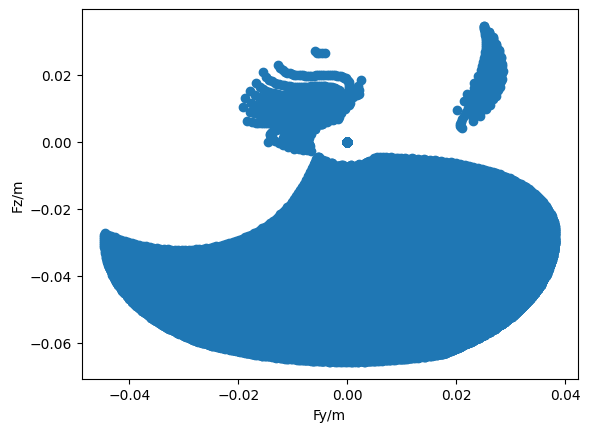

In [122]:
plt.scatter(result[:,0],result[:,1])
plt.xlabel("Fy/m")
plt.ylabel("Fz/m")

In [123]:
from Controller import MouseController
ETG_PATH = './data/ETG_models/Slope_ETG.npz'

EXP_ID=4
idx = 80
ETG_Evalpath = "./data/exp{}_ETG_models/slopeBest_{}.npz".format(EXP_ID, idx)
# ETG_Evalpath = os.path.join(script_directory,
#                             "data/ETG_models/Slope_ETG.npz")
info = np.load(ETG_Evalpath)
w = info["w"]
b = info["b"]
fre_frame = 5  #画面帧率控制或者说小鼠运动速度控制
fre = 0.5
time_step = 0.005
spine_angle = 0  #20

theController = MouseController(fre, time_step, spine_angle, ETG_PATH)
theController.update(w, b)

---->  400
angle -->  0
self.stepDiff: [0, 200, 200, 0, 0]


In [124]:
class ETG_layer():
    def __init__(self, T, dt, H, sigma_sq, phase, amp, T2_radio):
        #T2_ratio mean the ratio forward t,在这里基本表示着周期的一半
        self.dt = dt
        self.T = T
        self.t = 0
        self.H = H
        self.sigma_sq = sigma_sq
        self.phase = phase
        self.amp = amp
        self.u = []
        self.omega = 2.0 * np.pi / T
        self.T2_ratio = T2_radio
        for h in range(H):
            t_now = h * self.T / (H - 0.9)
            self.u.append(self.forward(t_now))
        #self.u包含了u_ij的信息
        self.u = np.asarray(self.u).reshape(-1, 2)
        self.TD = 0

    def forward(self, t):
        x = []
        for i in range(self.phase.shape[0]):
            x.append(self.amp * np.sin(self.phase[i] + t * self.omega))
        return np.asarray(x).reshape(-1)

    def update(self, t=None):
        '''
        用于计算P=W*V+b中的V
        '''
        time = t if t is not None else self.t
        x = self.forward(time)
        self.t += self.dt
        r = []
        for i in range(self.H):
            dist = np.sum(np.power(x - self.u[i], 2)) / self.sigma_sq
            r.append(np.exp(-dist))
        r = np.asarray(r).reshape(-1)
        return r

    def update2(self, t=None, info=None):
        '''
        用于计算t时刻的V和t+T/2时刻的V，这里要计算不同时刻的V是为了得到常用的步态，即rf和lh足部同向，
        lf和rh足部同向且和另两条腿相差T/2 phase
        '''
        time = t if t is not None else self.t
        x = self.forward(time)
        x2 = self.forward(time + self.T2_ratio * self.T)
        self.t += self.dt
        r = []
        for i in range(self.H):
            dist = np.sum(np.power(x - self.u[i], 2)) / self.sigma_sq
            r.append(np.exp(-dist))
        r = np.asarray(r).reshape(-1)
        r2 = []
        for i in range(self.H):
            dist = np.sum(np.power(x2 - self.u[i], 2)) / self.sigma_sq
            r2.append(np.exp(-dist))
        r2 = np.asarray(r2).reshape(-1)
        return (r, r2)

    def observation_T(self):
        ts = np.arange(0, self.T, self.dt)
        x = {t: self.forward(t) for t in ts}
        r_all = {}
        for j in ts:
            r = []
            for i in range(self.H):
                dist = np.sum(np.power(x[j] - self.u[i], 2)) / self.sigma_sq
                r.append(np.exp(-dist))
            r_all[j] = np.asarray(r).reshape(-1)
        return r_all

    def get_phase(self):
        return self.forward(self.t - self.dt)

    def reset(self):
        self.t = 0
        self.TD = 0
ETG_T=2
ETG_H=20
phase=np.array([-np.pi/2,0])
ETG_T2=0.5
ETG_dt=0.002
ETG_amp=0.2
ETG_agent = ETG_layer(ETG_T, ETG_dt, ETG_H, 0.04, phase, ETG_amp,
                          ETG_T2)

para_FU = [[-0.00, -0.045], [0.03, 0.01]]
para_FD = [[-0.00, -0.045], [0.03, 0.005]]
radSample=np.linspace(0,2*np.pi,10)
trj_ys=[]
trj_zs=[]
for cur_radian in radSample:
    if cur_radian<np.pi:
        originPoint=para_FU[0]
        ovalRadius=para_FU[1]
    else:
        originPoint=para_FD[0]
        ovalRadius=para_FD[1]
    trg_y = originPoint[0] + ovalRadius[0] * math.cos(cur_radian)
    trg_z = originPoint[1] + ovalRadius[1] * math.sin(cur_radian)
    trj_ys.append(trg_y)
    trj_zs.append(trg_z)
points=np.stack([trj_ys,trj_zs],axis=1)
def getETGinfo(points):
    b=np.mean(points,axis=0)
    points_t=points-b

    obs=[]
    # ts=radSample/(2*np.pi)*ETG_T
    ts=np.linspace(0,ETG_T,points.shape[0])
    for t in ts:
        v=ETG_agent.update(t)
        obs.append(v)
    obs=np.asarray(obs).reshape(-1,20)
    w=np.linalg.pinv(obs).dot(points_t)

    return w,b

In [125]:
pointsSlope=[[ 0.01547304, -0.04082316],
       [-0.02824815, -0.04302008],
       [-0.01718435, -0.05053774],
       [-0.00024149, -0.05153843],
       [ 0.02100094, -0.05227396]]
pointsSlope=np.asarray(pointsSlope)
def ETG_trj_plot(w,b):
    ts_new=np.linspace(0,ETG_T,100)
    obs1=[]
    for t in ts_new:
        v=ETG_agent.update(t)
        obs1.append(v)
    obs1=np.asarray(obs1).reshape(-1,20)
    points_new=obs1.dot(w)+b
    plt.plot(points_new[:,0],points_new[:,1],'g-',linewidth=3)
w_slope,b_slope=getETGinfo(pointsSlope)


In [126]:
ts= np.linspace(1, ETG_T*0.95, 5)
obs1 = []
for t in ts:
    v = theController.ETG_agent.update(t)
    obs1.append(v)
obs1 = np.asarray(obs1).reshape(-1, 20)
points_ETG= obs1.dot(w) + b
w_ETG,b_ETG=getETGinfo(points_ETG)

In [127]:
def saveETGinfo(path,w,b,param):
    np.savez(path,w=w,b=b,param=param)
path="./data/ETG_models/Slope_ETG_constrained.npz"
saveETGinfo(path,w_ETG,b_ETG,points_ETG)

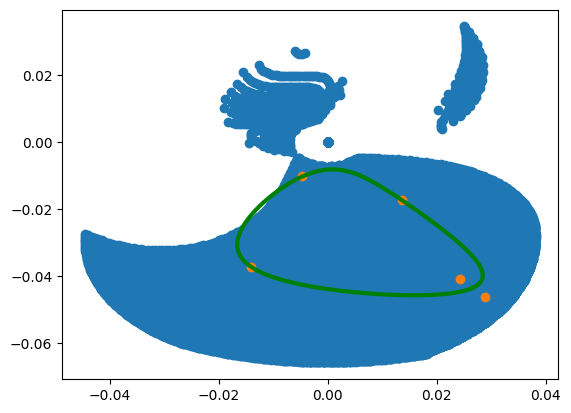

In [128]:
path_ETG="./data/exp3_ETG_models/slopeBest_400.npz"
info=np.load(path_ETG)
w_ETG,b_ETG=info["w"],info["b"]
plt.scatter(result[:,0],result[:,1])
plt.scatter(info["param"][:,0],info["param"][:,1])
ETG_trj_plot(w_ETG,b_ETG)


Text(0, 0.5, 'Fz/m')

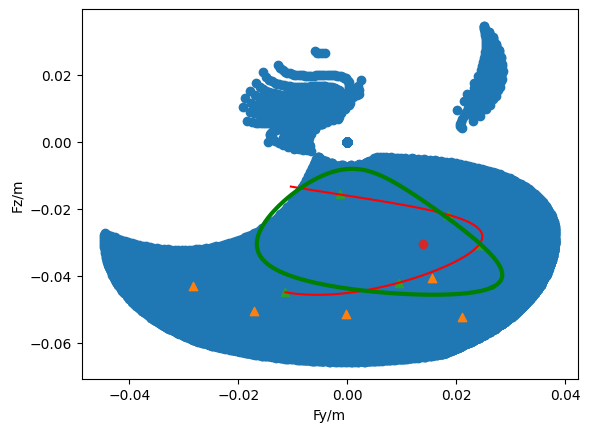

In [129]:
ETG_T = 2
ts_new = np.linspace(1, ETG_T, 100)
obs1 = []
for t in ts_new:
    v = theController.ETG_agent.update(t)
    obs1.append(v)
obs1 = np.asarray(obs1).reshape(-1, 20)
points_new = obs1.dot(w) + b
plt.plot(points_new[:, 0], points_new[:, 1],'r-')
plt.scatter(result[:,0],result[:,1])
ETG_trj_plot(w_ETG,b_ETG)
plt.scatter(pointsSlope[:,0],pointsSlope[:,1],marker='^')
plt.scatter(points_ETG[:,0],points_ETG[:,1],marker='^')
plt.scatter(angel_2_pos(0,0)[0],angel_2_pos(0,0)[1],marker='o')
plt.xlabel("Fy/m")
plt.ylabel("Fz/m")

In [130]:
angel_2_pos(0,0)

[0.013941939879705278, -0.03056178307842018]

In [131]:
def pos_2_angle(Fy, Fz):
    '''
    该函数实现了从足末端点坐标到电机角度的转换

    Parameters:
    -----------
    Fy, Fz: 足末端点的y坐标和z坐标
    '''
    By=0
    Bz=leg_params[1]
    AF = math.sqrt(Fy*Fy + Fz*Fz)
    a_FAy = math.acos(Fy/AF)
    if Fz > 0:
        a_FAy = - a_FAy
    a_FAE =  LawOfCosines_angle(AF, leg_params[0], leg_params[5])
    ## Need
    q1 = a_FAE - a_FAy
    #--------------------------------------
    Ey =  leg_params[0]*math.cos(q1)
    Ez =  leg_params[0]*math.sin(q1)

    DE_FE = leg_params[4]/leg_params[5]
    Dy = Ey + DE_FE*(Ey-Fy)
    Dz = Ez + DE_FE*(Ez-Fz)

    AD = math.sqrt(Dy*Dy + Dz*Dz)
    BD = math.sqrt(( By-Dy)*( By-Dy) + ( Bz-Dz)*( Bz-Dz))

    a_ABD =  LawOfCosines_angle(leg_params[1], BD, AD)
    a_DBC =  LawOfCosines_angle(leg_params[2], BD, leg_params[3])
    a_ABC = a_ABD + a_DBC

    q2 = a_ABC - math.pi
    return [q1, q2]

In [132]:
def pointsCheck(points):
    '''做一个简单的测试验证points对应的轨迹是否合法'''
    for point in points:
        q1,q2=pos_2_angle(*point)
        print("q1={},q2={}".format(q1,q2))
        if q1<-0.5*np.pi or q1>0.5*np.pi:
            return False
        if q2<-0.5*np.pi or q2>0.5*np.pi:
            return False
    return True
pointsCheck(points_ETG)

q1=-0.9626159491191413,q2=-1.1287895363953635
q1=-0.4174012232298471,q2=-0.36577375810313173
q1=0.11200625817086796,q2=0.5363229031605243
q1=0.3857087560893392,q2=0.608125338702409
q1=-0.07576174989448892,q2=-0.8324824636321031


True

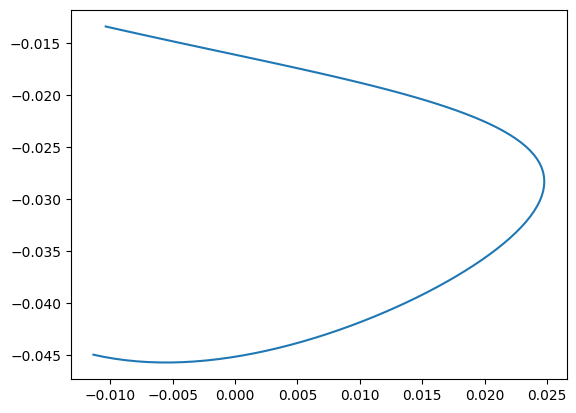

In [133]:
plt.plot(points_new[:,0],points_new[:,1])

In [134]:
results_ETG=[]
for id in np.arange(points_new.shape[0]):
    results_ETG.append(angel_2_pos(*pos_2_angle(points_new[id,0],points_new[id,1])))

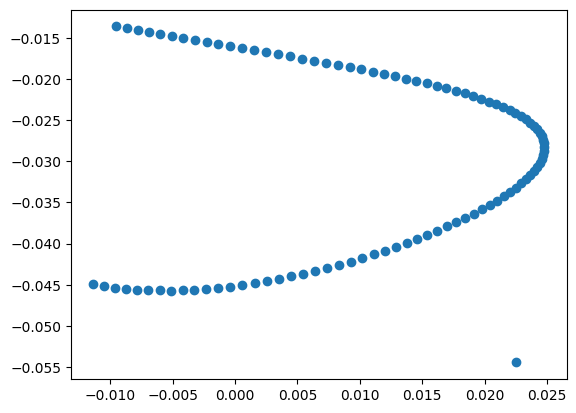

In [135]:
results_ETG=np.array(results_ETG)
plt.scatter(results_ETG[:,0],results_ETG[:,1])

In [136]:
# angel_2_pos(*pos_2_angle(points_new[id,0],points_new[id,1]))
id=15
print(points_new[id])
print(angel_2_pos(*pos_2_angle(*points_new[id])))


[ 0.00253022 -0.04457094]
[0.0025302158699645715, -0.044570944604710554]


In [137]:
pos_2_angle(*points_new[id])

[-0.6179920447135772, -0.653552182879098]